# HCNN theory

HCNN is a special case of recurrent neural network. Paper "Historical Consistent Complex Valued Recurrent Neural Network" contains detailed description.

**1. Variables:**

* $s_t - \text{hidden state vector of size } (1\times hidden\_dim)$ 
* $W - \text{weight matrix of size } (hidden\_dim\times hidden\_dim)$
* $\hat{y}_t - \text{prediction vector of size } 1\times data\_dim$
* $y_t - \text{target vector of size } 1\times data\_dim$
* $[Id, 0] =[Id_{data\_dim\times data\_dim}, 0_{(hidden\_dim - data\_dim)\times data\_dim}] - \text{transformation matrix from $s_t$ to $\hat{y}_t$ of size }  (data\_dim\times hidden\_dim)$
* $r_t - \text{vector in teacher forcing training of size } 1\times data\_dim$

**2. HCNN equations**

* $s_t = tanh(Ws_{t-1})$, with $s_0$ as random bias

* $\hat{y}_t = [Id, 0]s_t$

**3. Training process uses teacher forcing approach**

* $s_t = tanh(Wr_t)$

* $\hat{y}_t = [Id, 0]s_t$

* $r_t = s_{t} - [Id, 0](\hat{y}_{t} - y_{t})$ 

**4. Loss function**

* $E = \frac{1}{T}\sum_{t=1}^{T} E_t = \frac{1}{T}\sum_{t=1}^{T} (\hat{y}_t - y_t)^2$

* $E_t = (\hat{y}_t - y_t)^2 = \sum_{i=1}^{data\_dim} (\hat{y}_{t,\, i} - y_{t,\, i})$

**5. Backprop**

* $\frac{\partial E}{\partial W} = \sum_{t} \frac{\partial E_t}{\partial W}$

* $\frac{\partial E_t}{\partial W} = \frac{\partial E_t}{\partial \hat{y}_t}\frac{\partial \hat{y}_t}{\partial s_t}\frac{\partial s_t}{\partial W}$


* $\frac{\partial s_t}{\partial W} = \frac{\partial s_t(W,\, r_{t-1}(W,\, s_{t-1}))}{\partial W} = \frac{\partial s_t}{\partial W} + \frac{\partial s_{t}}{\partial r_{t-1}}\frac{\partial r_{t-1}}{\partial W} = \frac{\partial s_t}{\partial W} + \frac{\partial s_{t}}{\partial r_{t-1}}\left( \frac{\partial r_{t-1}}{\partial W} + \frac{\partial r_{t-1}}{\partial s_{t-1}}\frac{\partial s_{t-1}}{\partial W} \right) = \ldots$

* $\frac{\partial E_t}{\partial \hat{y}_t} = 2(\hat{y}_t - y_t)$
* $\frac{\partial \hat{y}_t}{\partial s_t} = [Id, 0]$
* $\frac{\partial s_t}{\partial r_{t-1}} = (1-s_t)^2W$
* $\frac{\partial s_t}{\partial W} = (1-s_t)^2 r_{t-1}$
* $\frac{\partial r_t}{\partial s_t} = 1$

# HCNN in Numpy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
% matplotlib inline
from matplotlib import colors as mcolors

import seaborn as sns
sns.set_style('darkgrid')

In [2]:
class HCNN_numpy:
    def __init__(self, data_dim, hidden_dim=10, sp=0.1):
        self.data_dim = data_dim
        self.hidden_dim = hidden_dim

        self.W = np.random.randn(hidden_dim, hidden_dim) * 0.1
        self.s2y = np.concatenate((np.eye(data_dim), np.zeros((hidden_dim-data_dim, data_dim))), axis=0)
    
    
    def init_state(self):
        return np.random.randn(self.hidden_dim) * 0.1
    
    
    def forward(self, init_state, data, W=None):
        W = self.W if W is None else W

        T = len(data)
        s = np.zeros((T+1, self.hidden_dim), dtype=np.float64)
        y = np.zeros((T, self.data_dim), dtype=np.float64)
        r = np.zeros((T+1, self.hidden_dim), dtype=np.float64)
        r[-1] = init_state.copy()
        s[-1] = init_state.copy()
        error = np.zeros(T)
        for t in range(T):
            s[t] = np.tanh(np.dot(W, r[t-1]))
            y[t] = np.dot(self.s2y.T, s[t])  # s[t][:data_dim]           

            error[t] = sum((y[t] - data[t])**2)

            # teacher forcing
            r[t] = s[t] - np.dot(self.s2y, y[t] - data[t]) 

        E = error.sum()
        return r, s, y, E
  
  
    def bptt(self, s, data, verbose=False):
        r, s, y, E = self.forward(s, data)
    
        dEdW = np.zeros(self.W.shape)
        for t in range(len(data)-1, -1, -1):        
            dEdy = 2*(y[t] - data[t])
            delta_t = self.s2y.dot(dEdy) * (1 - s[t] ** 2)
            
            for k in range(t, -1, -1):
                dEdW += np.outer(delta_t, r[k-1])
                delta_t = self.W.T.dot(delta_t) * (1 - s[k-1] ** 2)
        return dEdW, E
  
  
    def num_grad(self, s, data, delta = 1e-7):
        dEdW = np.zeros(self.W.shape)
        for i in range(self.W.shape[0]):
            for j in range(self.W.shape[1]):
                W_plus_delta, W_minus_delta = self.W.copy(), self.W.copy()
                W_plus_delta[i, j] += delta
                W_minus_delta[i, j] -= delta
                _, _, _, e1 = self.forward(s, data, W_plus_delta)
                _, _, _, e2 = self.forward(s, data, W_minus_delta)
                dEdW[i, j] = (e1 - e2)/(2*delta)
        return dEdW
  

    def fit(self, s, data, lr=0.01, epochs=10, grad='analytical', plot_loss=False):
        losses = []
        for e in range(epochs):
            if grad == 'analytical':
                dEdW, E = self.bptt(s, data)
            else:
                _, _, _, E = self.forward(s, data)
                dEdW = self.num_grad(s, data)

            self.W -= lr*dEdW
            losses.append(E)

            if plot_loss and (e+1)%10 == 0:
                fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
                ax[0].plot(np.arange(1, e+2), np.array(losses), 'grey')
                ax[0].set_xlabel('epoch')
                ax[0].set_ylabel('loss')
                ax[0].set_title(f'Traning loss on epoch {e+1}: {E}')
                
                pred = self.sample(s, int(len(data)*1.0))
                colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
                for c in range(data.shape[1]):
                    ax[1].plot(pred[:, c], '--', label=f'model {c+1}', color=colors[c], alpha=1)
                    ax[1].plot(data[:, c], label=f'actual {c+1}', color=colors[c], alpha=0.3)
                ax[1].set_title(f'predict (start from 0), epoch: {e+1}')
                legend_pred = ax[1].legend(frameon=True, loc='upper right')
                legend_pred.get_frame().set_color('white')

                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()

        return losses
    
    
    def sample(self, s, n=1):        
        y = np.zeros((n, self.data_dim), dtype=np.float64)
        for t in range(n):
            s = np.tanh(np.dot(self.W, s))
            y[t] = np.dot(self.s2y.T, s)
        return y

## Data

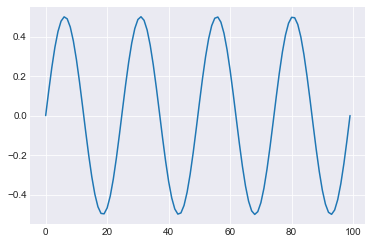

In [3]:
data = np.sin(np.linspace(-2*np.pi, 2*np.pi, 100)*2).reshape(-1, 1)/2
plt.plot(data)

## Build HCNN

In [4]:
np.random.seed(43)
model = HCNN_numpy(data_dim=data.shape[1], hidden_dim=5)
init_state = model.init_state()

In [5]:
# check that analytical and numerical gradients are the same (with some inaccuracy)
np.abs(model.bptt(init_state, data)[0] - model.num_grad(init_state, data))

array([[6.63002174e-01, 2.61067436e-02, 1.64161290e-02, 8.51020748e-03,
        4.02439725e-04],
       [5.58140836e-02, 1.73832421e-03, 1.11882270e-03, 5.02580771e-04,
        1.40557308e-04],
       [1.69466048e-02, 5.81045408e-04, 3.70172033e-04, 1.77356793e-04,
        2.24666833e-05],
       [3.14895775e-02, 9.89186121e-04, 6.36080721e-04, 2.87501195e-04,
        7.60776847e-05],
       [4.91458360e-02, 1.56877455e-03, 1.00697409e-03, 4.60292984e-04,
        1.09249625e-04]])

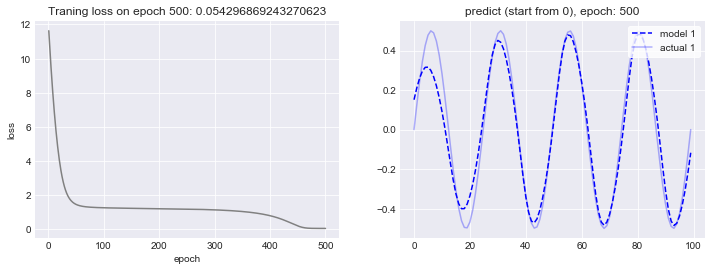

In [6]:
train_loss = model.fit(init_state, data, lr=0.001, epochs=500, grad='analytical', plot_loss=True)

# PLOT TRAIN LOSS
# plt.plot(range(1, len(train_loss)+1), train_loss)
# plt.xlabel('epoch'), plt.ylabel('loss'), plt.title('Traning loss (mse)'), plt.show()

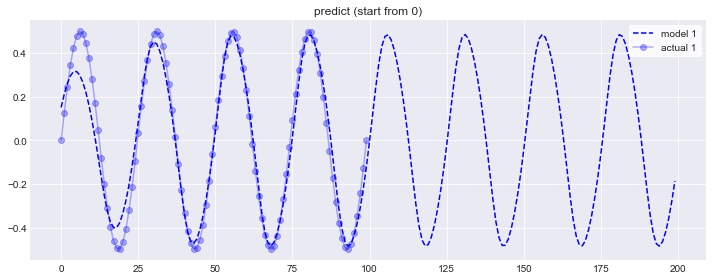

In [7]:
fig, ax = plt.subplots(figsize=(10, 4))

pred = model.sample(init_state, int(len(data)*2.0))
colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())
for c in range(data.shape[1]):
    ax.plot(pred[:, c], '--', label=f'model {c+1}', color=colors[c], alpha=1)
    ax.plot(data[:, c], 'o-', label=f'actual {c+1}', color=colors[c], alpha=0.3)
ax.set_title(f'predict (start from 0)')
legend_pred = ax.legend(frameon=True, loc='upper right')
legend_pred.get_frame().set_color('white')
plt.tight_layout()